# Web Scrapping

## Scrapping for Mercado Libre Colombia

Web scraping for the MercadoLibre platform, with the aim of obtaining information to answer the following questions:

- How are products distributed on MercadoLibre by price range?
- What features (free shipping, full price, promotions) are most common on MercadoLibre products?
- What issues or problems are most frequently mentioned in negative product reviews?
- Is there a relationship between seller ratings and the price categories in which they have the most sales?
- What words or terms appear most frequently in product reviews, and what do they tell us about the shopping experience?

In [16]:
# imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

In [17]:
# Function to build URLs with pagination

def get_pagination_urls(product_name, num_pages=5):
    urls = []
    formatted_product = product_name.replace(' ', '-')
    
    base_url = f"https://listado.mercadolibre.com.co/{formatted_product}"
    urls.append(base_url)
    
    for page in range(2, num_pages + 1):
        from_item = (page - 1) * 50 + 1
        pagination_url = f"https://listado.mercadolibre.com.co/{formatted_product}_Desde_{from_item}_NoIndex_True"
        urls.append(pagination_url)
    
    return urls

In [18]:
# Generate URLs for multiple pages

product = input("Which product do you want to search for? ")
product_name = product.replace(' ', '_')
# Define how many pages to scrape
num_pages = 5  # You can adjust this as needed

# Get list of URLs for all pages
urls = get_pagination_urls(product, num_pages)

print(f"{len(urls)} pages will be scraped:")
for i, url in enumerate(urls, 1):
    print(f"Page {i}: {url}")

5 pages will be scraped:
Page 1: https://listado.mercadolibre.com.co/carpinteria
Page 2: https://listado.mercadolibre.com.co/carpinteria_Desde_51_NoIndex_True
Page 3: https://listado.mercadolibre.com.co/carpinteria_Desde_101_NoIndex_True
Page 4: https://listado.mercadolibre.com.co/carpinteria_Desde_151_NoIndex_True
Page 5: https://listado.mercadolibre.com.co/carpinteria_Desde_201_NoIndex_True


In [19]:
# Scraping using requests and BeautifulSoup

data = []
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"  
}

for page_num, url in enumerate(urls, 1):
    print(f"Procesando página {page_num} de {len(urls)}: {url}")
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    products = soup.select(".ui-search-layout > li")
    print(f"  Se encontraron {len(products)} productos")

    for i, product in enumerate(products):
        # Extract title
        title_el = product.select_one("h3")
        title = title_el.get_text(strip=True) if title_el else ""

        # Extract price
        price_el = product.select_one(".andes-money-amount")
        price = price_el.get_text(strip=True) if price_el else ""

        # Extract link
        link_el = product.select_one("h3 a, .poly-component__title-wrapper > a")
        link = link_el["href"] if link_el else ""

        # Extract shipping information
        shipping = ""
        sd_el = product.select_one(".poly-shipping--next_day") or product.select_one(".poly-component__shipping")
        if sd_el:
            shipping = sd_el.get_text(strip=True)

        # Extract promotions
        promo_el = product.select_one(".poly-component__ads-promotions")
        promotion = promo_el.get_text(strip=True) if promo_el else ""

        # Extract FULL label
        full_el = product.select_one(".poly-component__shipped-from > svg")
        full = full_el.get("aria-label", "") if full_el else ""

        # Extract discount if available
        discount = ""
        disc_el = product.select_one(".ui-search-price__discount") or product.select_one(".andes-discount-badge")
        if disc_el:
            discount = disc_el.get_text(strip=True)

        # Initialize detail fields
        seller, comments_count, summary_text, reviews = "", "", "", []
        avg_rating, total_ratings = "", ""
        if link:
            try:
                prod_resp = requests.get(link, headers=headers)
                prod_soup = BeautifulSoup(prod_resp.text, "html.parser")
                # Seller info
                seller_el = prod_soup.select_one(".ui-seller-data-header__title") or prod_soup.select_one("h2")
                if seller_el:
                    seller = seller_el.get_text(strip=True).replace("Vendido por ", "")

                # Overall rating and count
                rating_sec = prod_soup.select_one(".ui-review-capability__rating")
                if rating_sec:
                    avg_el = rating_sec.select_one(".ui-review-capability__rating__average")
                    avg_rating = avg_el.get_text(strip=True) if avg_el else ""
                    label_el = rating_sec.select_one(".ui-review-capability__rating__label")
                    total_ratings = label_el.get_text(strip=True) if label_el else ""

                # Reviews summary and count
                section = prod_soup.select_one(".ui-review-capability-filter__comments")
                if section:
                    count_el = section.select_one(".total-opinion")
                    comments_count = count_el.get_text(strip=True) if count_el else ""
                    sum_el = section.select_one(".ui-review-capability__summary__plain_text__summary_container p")
                    summary_text = sum_el.get_text(strip=True) if sum_el else ""
                    # Individual comments
                    for cm in section.select(".ui-review-capability-comments__comment"):
                        rate_txt = cm.select_one(".ui-review-capability-comments__comment__rating-container .andes-visually-hidden").get_text(strip=True)
                        date = cm.select_one(".ui-review-capability-comments__comment__date").get_text(strip=True)
                        content_el = cm.select_one(".ui-review-capability-comments__comment__content")
                        text = content_el.get_text(strip=True) if content_el else ""
                        likes = cm.select_one(".ui-review-capability-valorizations__button-like__text").get_text(strip=True)
                        reviews.append({"rating": rate_txt, "date": date, "content": text, "likes": likes})
            except Exception:
                pass

        # Build product info dict
        product_info = {
            "title": title,
            "price": price,
            "link": link,
            "shipping": shipping,
            "seller": seller,
            "promotion": promotion,
            "full": full,
            "discount": discount,
            "avg_rating": avg_rating,
            "total_ratings": total_ratings,
            "comments_count": comments_count,
            "summary": summary_text,
            "reviews": reviews,
            "page": page_num
        }

        data.append(product_info)
        print(f"  Producto {i+1}: '{title[:30]}...' procesado")

    print(f"Página {page_num} completada. Total de productos hasta ahora: {len(data)}\n")
    time.sleep(2)

print(f"Proceso finalizado. Se recopilaron datos de {len(data)} productos en total.")


Procesando página 1 de 5: https://listado.mercadolibre.com.co/carpinteria
  Se encontraron 50 productos
  Se encontraron 50 productos
  Producto 1: 'Fresa Copiadora  38 Mm De Cort...' procesado
  Producto 1: 'Fresa Copiadora  38 Mm De Cort...' procesado
  Producto 2: 'Cepillo Para Madera Eléctrico ...' procesado
  Producto 2: 'Cepillo Para Madera Eléctrico ...' procesado
  Producto 3: 'Placa De Inserción De Mesa Par...' procesado
  Producto 3: 'Placa De Inserción De Mesa Par...' procesado
  Producto 4: 'Prensa Rápida Sargento X2 Unid...' procesado
  Producto 4: 'Prensa Rápida Sargento X2 Unid...' procesado
  Producto 5: 'Barra O Brazo De Soporte Teles...' procesado
  Producto 5: 'Barra O Brazo De Soporte Teles...' procesado
  Producto 6: 'Broca Forstner 35mm Con Tope D...' procesado
  Producto 6: 'Broca Forstner 35mm Con Tope D...' procesado
  Producto 7: 'Fresa Copiadora  38 Mm De Cort...' procesado
  Producto 7: 'Fresa Copiadora  38 Mm De Cort...' procesado
  Producto 8: 'Escuadra Ra

In [20]:
# Save results to CSV
import pandas as pd

df = pd.DataFrame(data)
df.to_csv(f"data_{product_name}.csv", index=False)

# Dashboard: Analysis and Visualization

In this section, we load the data we collect and generate visualizations that help you explore prices, ratings, discounts, and reviews.

In [35]:
# Cargar dataframe desde CSV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import defaultdict, Counter


# Cargar el dataset generado
df = pd.read_csv(f"data_{product_name}.csv")

NameError: name 'product_name' is not defined

### Gráficas

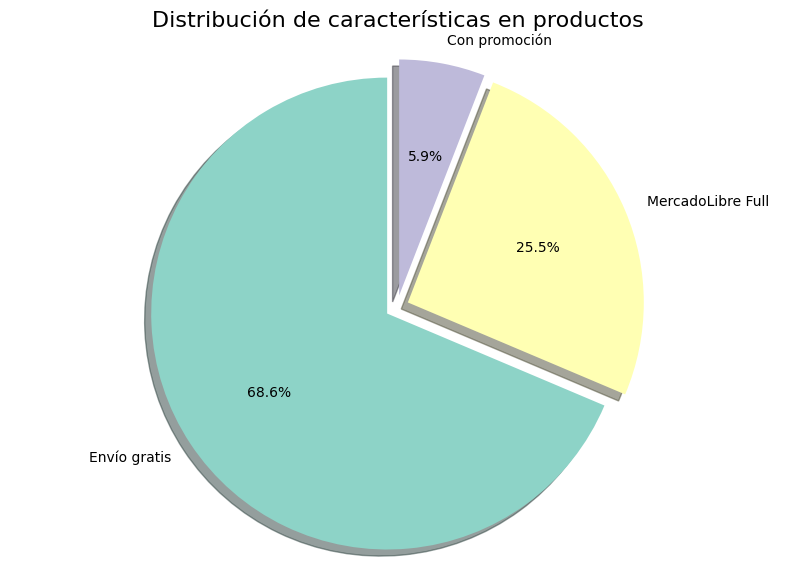

In [ ]:
# Convertir avg_rating a número si no se ha hecho antes
if 'avg_rating_num' not in df.columns:
    df['avg_rating_num'] = pd.to_numeric(df['avg_rating'], errors='coerce')

# Limpiar datos de precio para análisis
df['price_clean'] = df['price'].str.replace('[$.]', '', regex=True).str.replace(',', '.').astype(float)

# Preparar características asegurando que sean strings
features = {
    'Envío gratis': df['shipping'].fillna('').astype(str).str.contains('gratis|free', case=False),
    'MercadoLibre Full': df['full'].fillna('').astype(str).str.len() > 0,
    'Con promoción': df['promotion'].fillna('').astype(str).str.len() > 0,
}

# Contar características
feature_counts = {name: sum(values) for name, values in features.items()}

# Crear gráfico de torta
plt.figure(figsize=(10, 7))
plt.pie(
    feature_counts.values(),
    labels=feature_counts.keys(),
    autopct='%1.1f%%',
    startangle=90,
    shadow=True,
    explode=[0.05] * len(feature_counts),
    colors=plt.cm.Set3.colors
)
plt.title('Distribución de características en productos', fontsize=16)
plt.axis('equal')
plt.show()

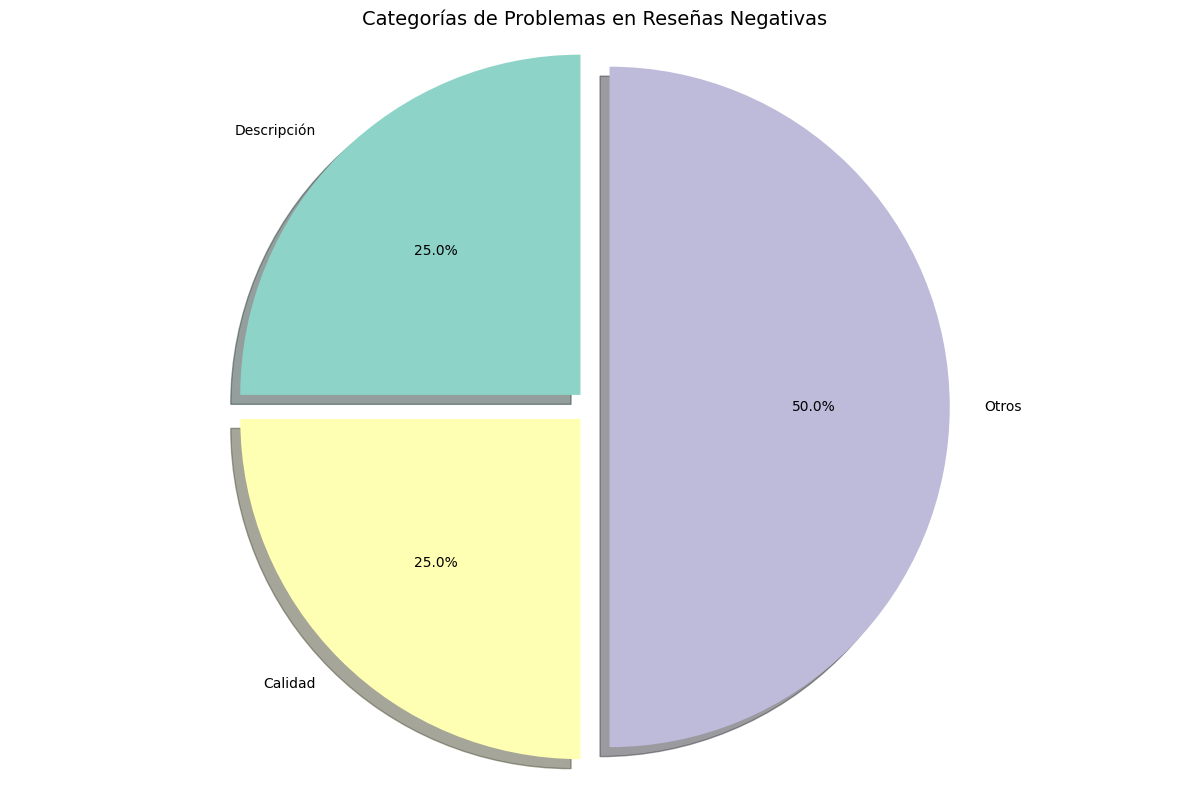

In [ ]:
try:
    # Convertir la columna reviews y extraer reseñas negativas
    df['reviews_list'] = df['reviews'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip() and x.strip() != '[]' else []
    )
    
    # Extraer reseñas negativas
    negative_reviews = []
    for reviews in df['reviews_list']:
        for review in reviews:
            if isinstance(review, dict):
                rating_text = str(review.get('rating', '')).lower()
                if ('calificación 1' in rating_text or 'calificación 2' in rating_text):
                    content = str(review.get('content', ''))
                    if content.strip():
                        negative_reviews.append(content)

    if not negative_reviews:
        print("No se encontraron reseñas negativas reales, usando datos de ejemplo...")
        negative_reviews = [
            "El producto llegó con retraso y en mal estado.",
            "La calidad no es como se muestra en las fotos.",
            "Caro para lo que ofrece, no lo recomiendo.",
            "No funciona como debería, me decepcionó.",
            "La descripción no coincide con el producto real."
        ]

    # Análisis por categorías predefinidas
    problem_categories = {
        'Envío': ['envío', 'envio', 'entrega', 'demora', 'tardó', 'llegó tarde'],
        'Calidad': ['calidad', 'malo', 'mala', 'defecto', 'roto', 'dañado'],
        'Precio': ['caro', 'precio', 'costoso', 'valor', 'dinero'],
        'Funcionalidad': ['funciona', 'sirve', 'uso', 'inútil', 'no sirve'],
        'Descripción': ['descripción', 'diferente', 'engaño', 'publicidad falsa'],
        'Atención': ['atención', 'vendedor', 'servicio', 'respuesta']
    }

    # Categorizar reseñas y contar frecuencias
    categories = defaultdict(int)
    for review in negative_reviews:
        review_lower = review.lower()
        categorized = False
        for category, keywords in problem_categories.items():
            if any(keyword in review_lower for keyword in keywords):
                categories[category] += 1
                categorized = True
        if not categorized:
            categories['Otros'] += 1

    # Crear gráfico de torta
    plt.figure(figsize=(12, 8))
    plt.pie(
        categories.values(),
        labels=categories.keys(),
        autopct='%1.1f%%',
        startangle=90,
        shadow=True,
        explode=[0.05] * len(categories),
        colors=plt.cm.Set3.colors
    )
    plt.title('Categorías de Problemas en Reseñas Negativas', fontsize=14)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error en el análisis: {e}")
    # Mostrar gráfico de ejemplo en caso de error
    plt.figure(figsize=(12, 8))
    example_data = {'Envío': 5, 'Calidad': 4, 'Precio': 3, 
                   'Funcionalidad': 3, 'Descripción': 2, 'Otros': 1}
    plt.pie(
        example_data.values(),
        labels=example_data.keys(),
        autopct='%1.1f%%',
        startangle=90,
        shadow=True,
        explode=[0.05] * len(example_data),
        colors=plt.cm.Set3.colors
    )
    plt.title('Categorías de Problemas (DATOS DE EJEMPLO)', fontsize=14)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

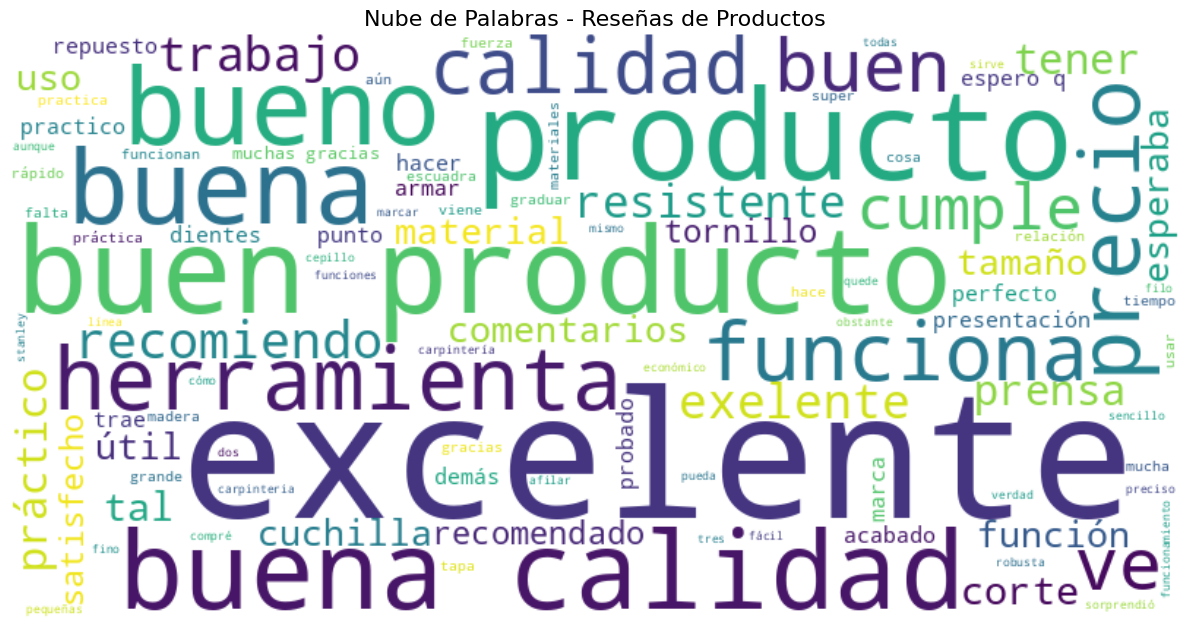

Total de reseñas analizadas: 243
Promedio de palabras por reseña: 9.1


In [ ]:
try:
    # Preparar NLTK para eliminar stopwords
    try:
        stopwords_spanish = set(stopwords.words('spanish'))
    except:
        nltk.download('stopwords')
        stopwords_spanish = set(stopwords.words('spanish'))
    
    # Añadir algunas stopwords personalizadas
    stopwords_spanish.update(['si', 'pero', 'muy', 'bien', 'todo', 'con', 'sin', 'ya', 'las', 'los', 'del', 'solo'])
    
    # Extraer todas las reseñas (no solo las negativas)
    all_reviews = []
    for reviews in df['reviews_list']:
        for review in reviews:
            if isinstance(review, dict):
                content = str(review.get('content', ''))
                if content.strip():
                    all_reviews.append(content)
    
    if not all_reviews:
        print("No se encontraron reseñas, usando datos de ejemplo...")
        all_reviews = [
            "El producto llegó rápido y en buen estado",
            "Excelente calidad y precio",
            "No me gustó la calidad del material",
            "Funciona muy bien, lo recomiendo",
            "El envío fue muy lento pero el producto cumple su función",
            "Color distinto al de la imagen",
            "El vendedor tiene buena atención",
            "Buen producto para su precio",
            "No sirve como esperaba",
            "La mejor compra que he hecho"
        ]
    
    # Preprocesar el texto para la nube de palabras
    reviews_text = " ".join(all_reviews).lower()
    
    # Crear la nube de palabras
    plt.figure(figsize=(12, 8))
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100,
        contour_width=3,
        contour_color='steelblue',
        stopwords=stopwords_spanish
    ).generate(reviews_text)
    
    # Visualizar la nube de palabras
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de Palabras - Reseñas de Productos', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Mostrar estadísticas sobre las reseñas
    print(f"Total de reseñas analizadas: {len(all_reviews)}")
    print(f"Promedio de palabras por reseña: {sum(len(r.split()) for r in all_reviews) / len(all_reviews):.1f}")

except Exception as e:
    print(f"Error al generar la nube de palabras: {e}")
    # Mostrar nube de palabras de ejemplo
    example_text = "calidad producto bueno excelente recomendado funciona bien precio envío rápido vendedor atención " * 5
    plt.figure(figsize=(12, 8))
    example_cloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=50
    ).generate(example_text)
    plt.imshow(example_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de Palabras (DATOS DE EJEMPLO)', fontsize=16)
    plt.show()

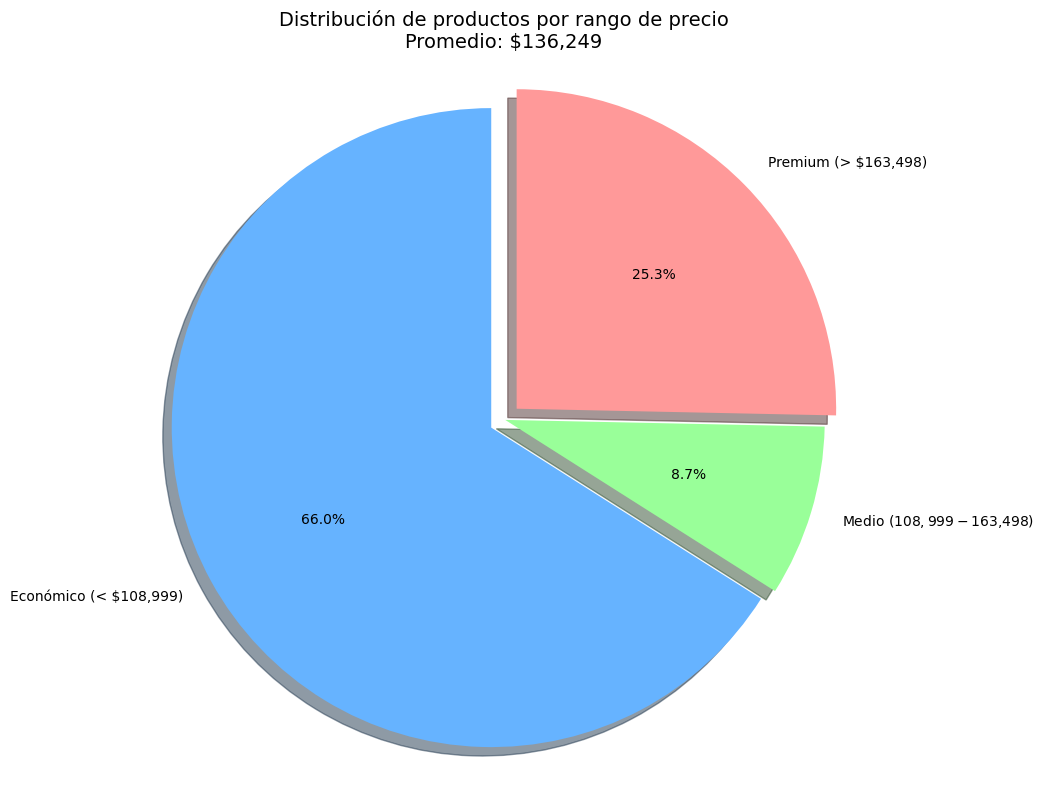

Económico (< $108,999): 99 productos (66.0%)
Medio ($108,999 - $163,498): 13 productos (8.7%)
Premium (> $163,498): 38 productos (25.3%)


In [ ]:
try:
    # Asegurar que tenemos la columna de precio limpia
    if 'price_clean' not in df.columns:
        df['price_clean'] = df['price'].str.replace('[$.]', '', regex=True).str.replace(',', '.').astype(float)
    
    # Calcular estadísticas de precio
    precio_promedio = df['price_clean'].mean()
    desviacion = df['price_clean'].std()
    
    # Definir categorías de precio según el promedio
    umbral_bajo = precio_promedio * 0.8
    umbral_alto = precio_promedio * 1.2
    
    # Etiquetas con rangos reales de precios
    etiquetas = [
        f"Económico (< ${umbral_bajo:,.0f})",
        f"Medio (${umbral_bajo:,.0f} - ${umbral_alto:,.0f})",
        f"Premium (> ${umbral_alto:,.0f})"
    ]
    
    # Clasificar productos
    valores = [
        df[df['price_clean'] < umbral_bajo].shape[0],
        df[(df['price_clean'] >= umbral_bajo) & (df['price_clean'] <= umbral_alto)].shape[0],
        df[df['price_clean'] > umbral_alto].shape[0]
    ]
    
    # Crear gráfico de torta
    plt.figure(figsize=(10, 8))
    plt.pie(
        valores,
        labels=etiquetas,
        autopct='%1.1f%%',  # Mantenemos porcentajes como información adicional
        startangle=90,
        shadow=True,
        explode=[0.05, 0, 0.05],
        colors=['#66b3ff', '#99ff99', '#ff9999']
    )
    plt.title(f'Distribución de productos por rango de precio\nPromedio: ${precio_promedio:,.0f}', fontsize=14)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # Mostrar tabla con rangos y conteo
    for i, etiqueta in enumerate(etiquetas):
        cantidad = valores[i]
        print(f"{etiqueta}: {cantidad} productos ({cantidad/df.shape[0]*100:.1f}%)")
    
except Exception as e:
    print(f"Error al analizar precios: {e}")
    # Mostrar gráfico de ejemplo en caso de error
    plt.figure(figsize=(10, 8))
    example_data = {'< $100,000': 25, '$100,000 - $150,000': 15, '> $150,000': 10}
    plt.pie(
        example_data.values(),
        labels=example_data.keys(),
        autopct='%1.1f%%',
        startangle=90,
        shadow=True,
        explode=[0.05, 0, 0.05],
        colors=['#66b3ff', '#99ff99', '#ff9999']
    )
    plt.title('Distribución de productos por rango de precio (DATOS DE EJEMPLO)', fontsize=14)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

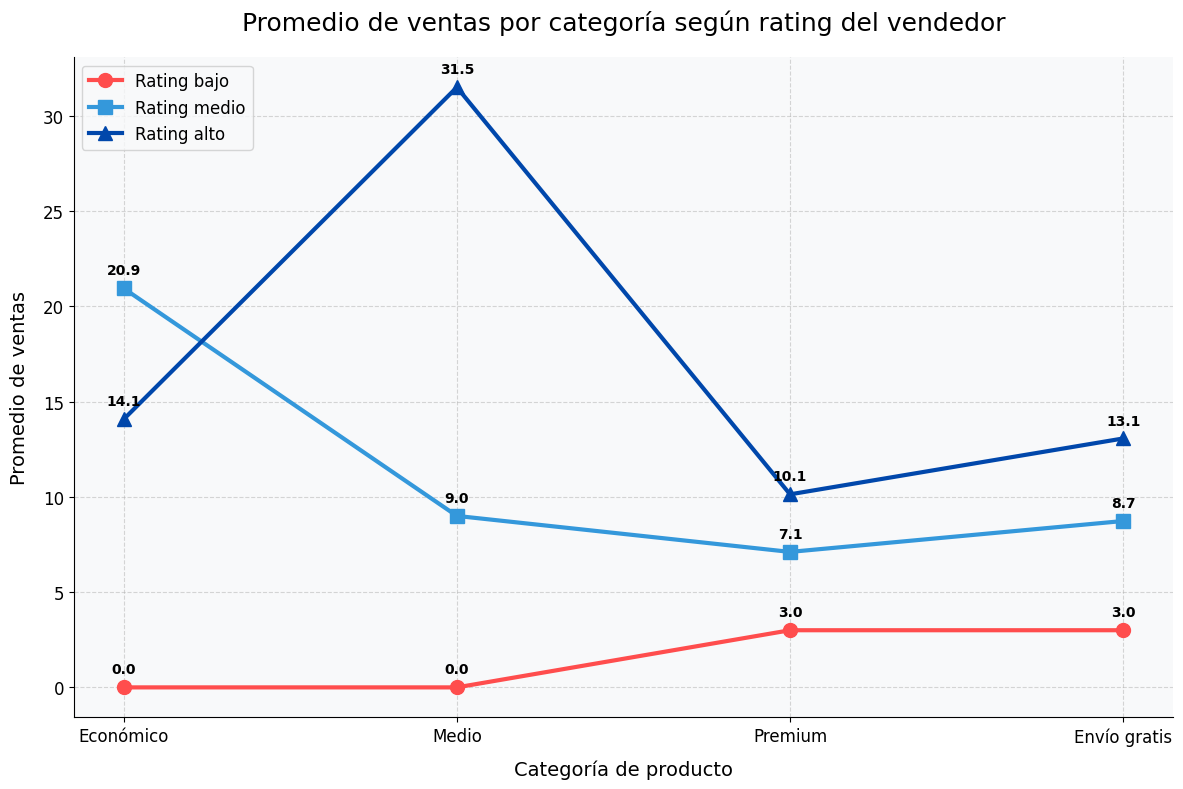


--- Distribución de productos por categoría ---
Económico: 99 productos (66.0%)
Medio: 13 productos (8.7%)
Premium: 38 productos (25.3%)
Con envío gratis: 70 productos (46.7%)


In [ ]:
try:
    # Asegurar que tenemos la columna de rating convertida a número
    if 'avg_rating_num' not in df.columns:
        df['avg_rating_num'] = pd.to_numeric(df['avg_rating'], errors='coerce')
    
    # Categorizar vendedores por rating
    df['rating_categoria'] = pd.cut(
        df['avg_rating_num'],
        bins=[0, 3.5, 4.5, 5.1],
        labels=['Rating bajo', 'Rating medio', 'Rating alto']
    )
    
    # Categorizar productos por rango de precio
    precio_promedio = df['price_clean'].mean()
    umbral_bajo = precio_promedio * 0.8
    umbral_alto = precio_promedio * 1.2
    
    df['precio_categoria'] = pd.cut(
        df['price_clean'],
        bins=[0, umbral_bajo, umbral_alto, float('inf')],
        labels=['Económico', 'Medio', 'Premium']
    )
    
    # Identificar características clave
    df['envio_gratis'] = df['shipping'].fillna('').str.contains('gratis|free', case=False)
    df['es_full'] = df['full'].fillna('').astype(str).str.len() > 0
    
    # Crear categorías para el eje X
    categorias = ['Económico', 'Medio', 'Premium', 'Envío gratis']
    
    # Preparar datos para la gráfica - ventas estimadas por categoría y rating
    datos_grafico = {
        'Rating bajo': [],
        'Rating medio': [], 
        'Rating alto': []
    }
    
    # Agregar la columna de ventas estimadas al DataFrame principal
    # Usamos expresión regular con r para solucionar el error de escape
    df['ventas_estimadas'] = df['total_ratings'].str.extract(r'(\d+)').astype(float)
    
    # Calcular promedios para cada combinación
    # Para los tres rangos de precio
    for precio_cat in ['Económico', 'Medio', 'Premium']:
        for rating_cat in ['Rating bajo', 'Rating medio', 'Rating alto']:
            subset = df[(df['precio_categoria'] == precio_cat) & (df['rating_categoria'] == rating_cat)]
            if len(subset) > 0:
                promedio = subset['ventas_estimadas'].mean()
                datos_grafico[rating_cat].append(promedio if not pd.isna(promedio) else 0)
            else:
                datos_grafico[rating_cat].append(0)
    
    # Para envío gratis
    for rating_cat in ['Rating bajo', 'Rating medio', 'Rating alto']:
        subset = df[(df['envio_gratis'] == True) & (df['rating_categoria'] == rating_cat)]
        if len(subset) > 0:
            promedio = subset['ventas_estimadas'].mean()
            datos_grafico[rating_cat].append(promedio if not pd.isna(promedio) else 0)
        else:
            datos_grafico[rating_cat].append(0)
    
    # Crear gráfico
    plt.figure(figsize=(12, 8))
    
    # Colores modificados: rojo para bajo, azul para medio, azul oscuro para alto
    colores = ['#FF4D4D', '#3498DB', '#0047AB']
    marcadores = ['o', 's', '^']
    
    # Gráfico de líneas con puntos destacados
    for i, (rating, valores) in enumerate(datos_grafico.items()):
        plt.plot(categorias, valores, marker=marcadores[i], linestyle='-', 
                 linewidth=3, markersize=10, label=rating, color=colores[i])
    
    # Mejorar aspecto visual
    plt.title('Promedio de ventas por categoría según rating del vendedor', fontsize=18, pad=20)
    plt.xlabel('Categoría de producto', fontsize=14, labelpad=10)
    plt.ylabel('Promedio de ventas', fontsize=14, labelpad=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12, loc='upper left', frameon=True, facecolor='#f8f9fa')
    
    # Personalizar fondo y ejes
    plt.gca().set_facecolor('#f8f9fa')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Mostrar valores en los puntos
    for i, (rating, valores) in enumerate(datos_grafico.items()):
        for j, valor in enumerate(valores):
            plt.annotate(f'{valor:.1f}', (j, valor), 
                         textcoords="offset points", 
                         xytext=(0,10), 
                         ha='center', 
                         fontsize=10,
                         fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    # Mostrar estadísticas adicionales
    print(f"\n--- Distribución de productos por categoría ---")
    for cat in categorias[:3]:  # Solo las categorías de precio
        productos = df[df['precio_categoria'] == cat].shape[0]
        porcentaje = productos / df.shape[0] * 100
        print(f"{cat}: {productos} productos ({porcentaje:.1f}%)")
    
    envio_gratis = df[df['envio_gratis'] == True].shape[0]
    print(f"Con envío gratis: {envio_gratis} productos ({envio_gratis / df.shape[0] * 100:.1f}%)")

except Exception as e:
    print(f"Error al crear gráfico: {e}")
    
    # Datos de ejemplo para mostrar en caso de error
    categorias = ['Económico', 'Medio', 'Premium', 'Envío gratis']
    datos_ejemplo = {
        'Rating bajo': [12.3, 8.5, 5.2, 15.7],
        'Rating medio': [18.4, 22.1, 28.3, 19.5],
        'Rating alto': [25.6, 32.4, 38.9, 30.1]
    }
    
    plt.figure(figsize=(12, 8))
    colores = ['#FF4D4D', '#3498DB', '#0047AB']
    marcadores = ['o', 's', '^']
    
    for i, (rating, valores) in enumerate(datos_ejemplo.items()):
        plt.plot(categorias, valores, marker=marcadores[i], linestyle='-', 
                 linewidth=3, markersize=10, label=rating, color=colores[i])
    
    plt.title('Promedio de ventas por categoría según rating del vendedor (EJEMPLO)', fontsize=18, pad=20)
    plt.xlabel('Categoría de producto', fontsize=14, labelpad=10)
    plt.ylabel('Promedio de ventas', fontsize=14, labelpad=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12, loc='upper left', frameon=True, facecolor='#f8f9fa')
    
    plt.gca().set_facecolor('#f8f9fa')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    for i, (rating, valores) in enumerate(datos_ejemplo.items()):
        for j, valor in enumerate(valores):
            plt.annotate(f'{valor:.1f}', (j, valor), 
                         textcoords="offset points", 
                         xytext=(0,10), 
                         ha='center', 
                         fontsize=10, 
                         fontweight='bold')
    
    plt.tight_layout()
    plt.show()